In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
Base.metadata.create_all(engine)
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [9]:
# inspect the tables (what columns are in each table?)
inspector = inspect(engine)
columns = inspector.get_columns('station')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Find the most recent date in the data set.
#recent_date = session.query(Measurement).order_by(Measurement.date.desc()).first()
recent_date = session.query(func.max(Measurement.date)).first()
print(recent_date)

('2017-08-23',)


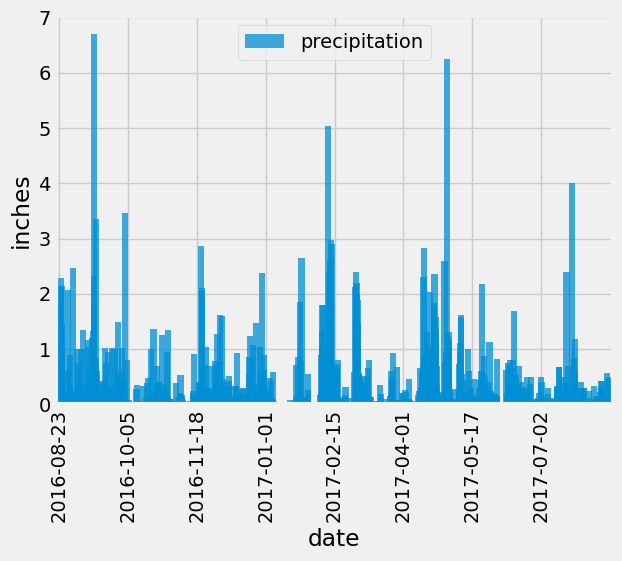

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
#print(date)

# Perform a query to retrieve the data and precipitation scores
twelve_months = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= date).all()
#print(twelve_months)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(twelve_months, columns=['date', 'prcp'])
prcp_df = prcp_df.rename(columns={"prcp":"precipitation"})

# Sort the dataframe by date
prcp_df = prcp_df.set_index(prcp_df['date'])
prcp_df = prcp_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(kind='bar', alpha=0.75, width=25, grid=True)
plt.xlabel('date')
plt.ylabel('inches')
plt.locator_params(axis='x', nbins=8)
plt.show()



In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
sum_stats_df = pd.DataFrame(prcp_df['precipitation'].describe())
sum_stats_df

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
station_num = session.query(func.count(Station.station)).all()
print(station_num)


[(9,)]


In [30]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_desc = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()

print(station_desc)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [31]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [func.min(Measurement.tobs), func.max(Measurement.tobs),\
       (func.round(func.avg(Measurement.tobs),1))]

stat_sum = session.query(*sel).\
filter(Measurement.station == 'USC00519281').all()

print(stat_sum)

[(54.0, 85.0, 71.7)]


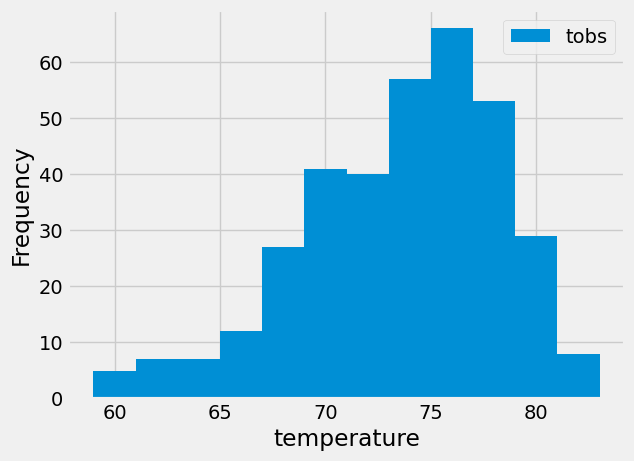

In [32]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_of_tobs = session.query(Measurement.tobs).\
    filter(Measurement.date >= date).\
    where(Measurement.station == 'USC00519281').all()

tobs_df = pd.DataFrame(year_of_tobs)

tobs_df.plot(kind='hist', bins=12)
plt.xlabel('temperature')
plt.show()

# Close Session

In [17]:
# Close Session
session.close()